In [1]:
# build module
!python setup.py build -j 8

running build
running build_ext
building 'openstorm_radar_native' extension
C:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MT "-Ic:\Program Files\Python37\include" "-Ic:\Program Files\Python37\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.29.30133\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.8\include\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\winrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.19041.0\cppwinrt" /EHsc /Tpbinding.cpp /Fobuild\temp.win-amd64-3.7\Release\binding.obj
binding.cpp

In [2]:
import sys
import os
import numpy as np
import time
import math
import matplotlib.animation
import IPython
from matplotlib import pyplot as plt

#%config InlineBackend.figure_formats = ['svg']
#%config InlineBackend.figure_formats = ['jpeg']
%config InlineBackend.figure_formats = ['retina']
#%config InlineBackend.figure_formats = ['png']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["figure.figsize"] = (7, 7)


sys.path.insert(0, '../')
import openstorm_radar_py

In [3]:
# RadarData is the most basic unit of OpenStorm radar and contains a single volume of radar
radar_data = openstorm_radar_py.RadarData()
# load file and extract a single basic radar type. 
# These files can be found in the release of OpenStorm, copy them into the git repo for this to work.
#radar_data.load_nexrad_file("../OpenStorm/Content/Data/Demo/KMKX_20220723_235820", openstorm_radar_py.VolumeTypes.VOLUME_REFLECTIVITY)
#radar_data.load_nexrad_file("../OpenStorm/Content/Data/Demo/KTLX20130531_231434_V06", openstorm_radar_py.VolumeTypes.VOLUME_REFLECTIVITY)
radar_data.load_nexrad_file("../OpenStorm/Content/Data/Demo/KLCH20200827_034044_V06", openstorm_radar_py.VolumeTypes.VOLUME_REFLECTIVITY)
if 0:
	realtime_data_dir = "../radar-data/data/KMKX/"
	radar_data.load_nexrad_file(realtime_data_dir + os.listdir(realtime_data_dir)[-1], openstorm_radar_py.VolumeTypes.VOLUME_REFLECTIVITY)

In [4]:
# get information about the radar volume
stats = radar_data.get_stats()
stats

{'inner_distance': 8.5,
 'min_value': -20.0,
 'max_value': 65.0,
 'pixel_size': 250.0,
 'begin_time': 1598499644.2789993,
 'end_time': 1598500038.4160004,
 'no_data_value': -inf,
 'bound_radius': 1829.5,
 'bound_upper': 85.33491516113281,
 'bound_lower': 1.000000013351432e-10,
 'latitude': 30.125306,
 'longitude': -93.215889,
 'altitude': 41.75768351533701,
 'volume_type': 1}

In [5]:
sweepInfo = radar_data.get_sweep_info()
sweepInfo

[{'elevation': 0.483394980430603, 'id': 0, 'actual_ray_count': 720},
 {'elevation': 0.8789100050926208, 'id': 1, 'actual_ray_count': 720},
 {'elevation': 1.3183599710464478, 'id': 2, 'actual_ray_count': 720},
 {'elevation': 1.8017549514770508, 'id': 3, 'actual_ray_count': 360},
 {'elevation': 2.416995048522949, 'id': 4, 'actual_ray_count': 360},
 {'elevation': 3.120115041732788, 'id': 5, 'actual_ray_count': 360},
 {'elevation': 3.9990248680114746, 'id': 6, 'actual_ray_count': 360},
 {'elevation': 5.097660064697266, 'id': 7, 'actual_ray_count': 360},
 {'elevation': 6.416019916534424, 'id': 8, 'actual_ray_count': 360},
 {'elevation': 7.998049736022949, 'id': 9, 'actual_ray_count': 360},
 {'elevation': 10.019530296325684, 'id': 10, 'actual_ray_count': 360},
 {'elevation': 11.997075080871582, 'id': 11, 'actual_ray_count': 360},
 {'elevation': 14.0185546875, 'id': 12, 'actual_ray_count': 360},
 {'elevation': 16.69921875, 'id': 13, 'actual_ray_count': 360},
 {'elevation': 19.51171875, 'id': 

In [6]:
# convert to numpy array
# there are 2 duplicated rays in each sweep that are used for padding for interpolation. In most cases they should be ignored or removed like below.
# The first dimension is the sweep the second is the rotation and the third is the distance away from the radar.
# You will see the dimensions refereed to as sweep, theta, and radius in code.
print(radar_data.buffer)
buffer = np.array(radar_data.buffer)[:,1:-1,:]
print(buffer.shape)

(15, 720, 1832)


In [7]:
# get a pixel's position for a latitude and longitude
location = radar_data.get_pixel_for_location(stats["latitude"] - 1, stats["longitude"] + 1, 3000)
print("get_pixel_for_location output", location)
try:
	# get pixel in buffer
	pixel_location = (math.floor(location["sweep"]), math.floor(location["theta"]), math.floor(location["radius"]))
	print("pixel location:", pixel_location)
	print("pixel value:", buffer[pixel_location[0], pixel_location[1], pixel_location[2]])
except:
	pass

# invalid example below lowest sweep
print("invalid output", radar_data.get_pixel_for_location(stats["latitude"] - 0.1, stats["longitude"] + 0.1, 0))
print("radar space location", radar_data.get_radar_space_for_location(stats["latitude"] - 0.1, stats["longitude"] + 0.1, 0))


get_pixel_for_location output {'is_in_volume': True, 'sweep': 1.5102465152740479, 'theta': 277.5041198730469, 'radius': 581.0751342773438, 'pixel_radius_length': 250.0, 'pixel_theta_width': 1286.25341796875, 'value': 30.0}
pixel location: (1, 277, 581)
pixel value: 30.0
invalid output {'is_in_volume': False, 'sweep': -inf, 'theta': 278.2061767578125, 'radius': 50.32008361816406, 'pixel_radius_length': 250.0, 'pixel_theta_width': 128.3255157470703}
radar space location (9627.301707733786, 11115.270413046237, -58.72789718024433)


In [8]:
# a function to correctly plot sweep buffers
def plot_radial_image(buffer):
	theta, rad = np.meshgrid(np.linspace(np.pi * 2.5, np.pi * 0.5, buffer.shape[0]), np.linspace(0, buffer.shape[1], buffer.shape[1]))
	#print(theta.shape, rad.shape)
	fig = plt.figure()
	ax = fig.add_subplot(111, polar='True')
	ax.pcolormesh(theta, rad, np.transpose(buffer), shading='auto')
	plt.show()

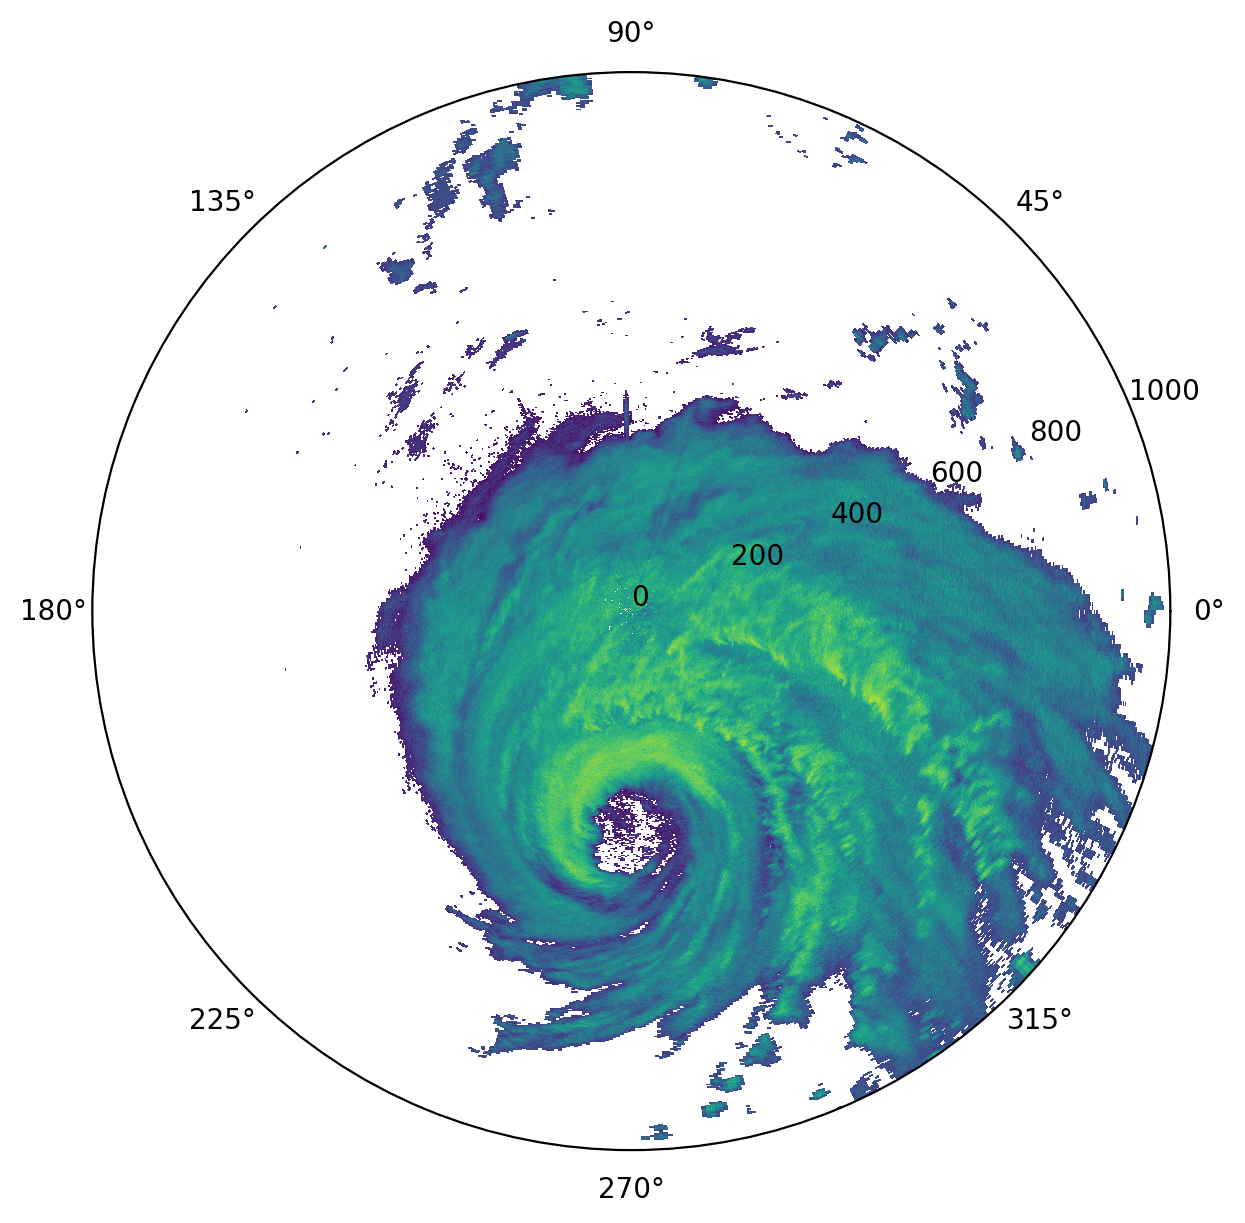

In [9]:
plot_radial_image(buffer[0,:,:1000])
#plot_radial_image(np.clip(buffer[5,:,:1000], -100, 100))

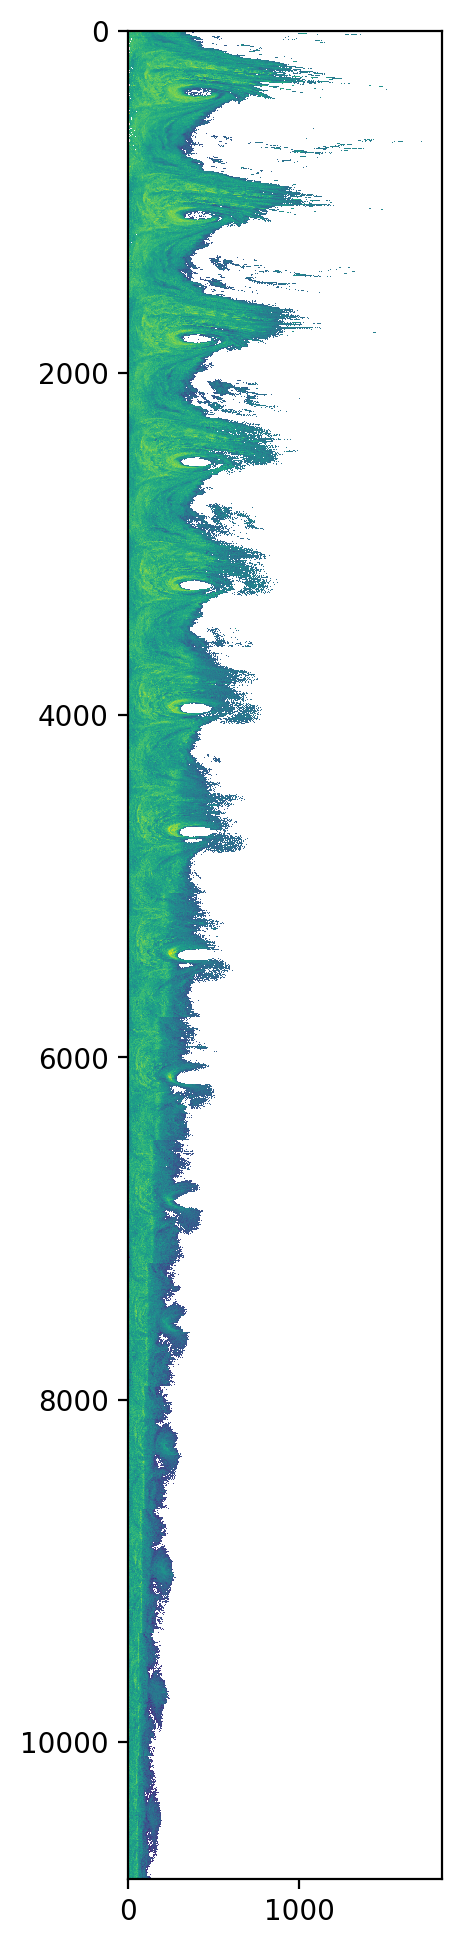

In [10]:

# plot entire buffer on rectangular image
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()
ax.imshow(np.concatenate(buffer), interpolation='nearest')
plt.show()
#plt.imshow(np.flattennp.clip(buffer[0], -20, 100), interpolation='nearest')

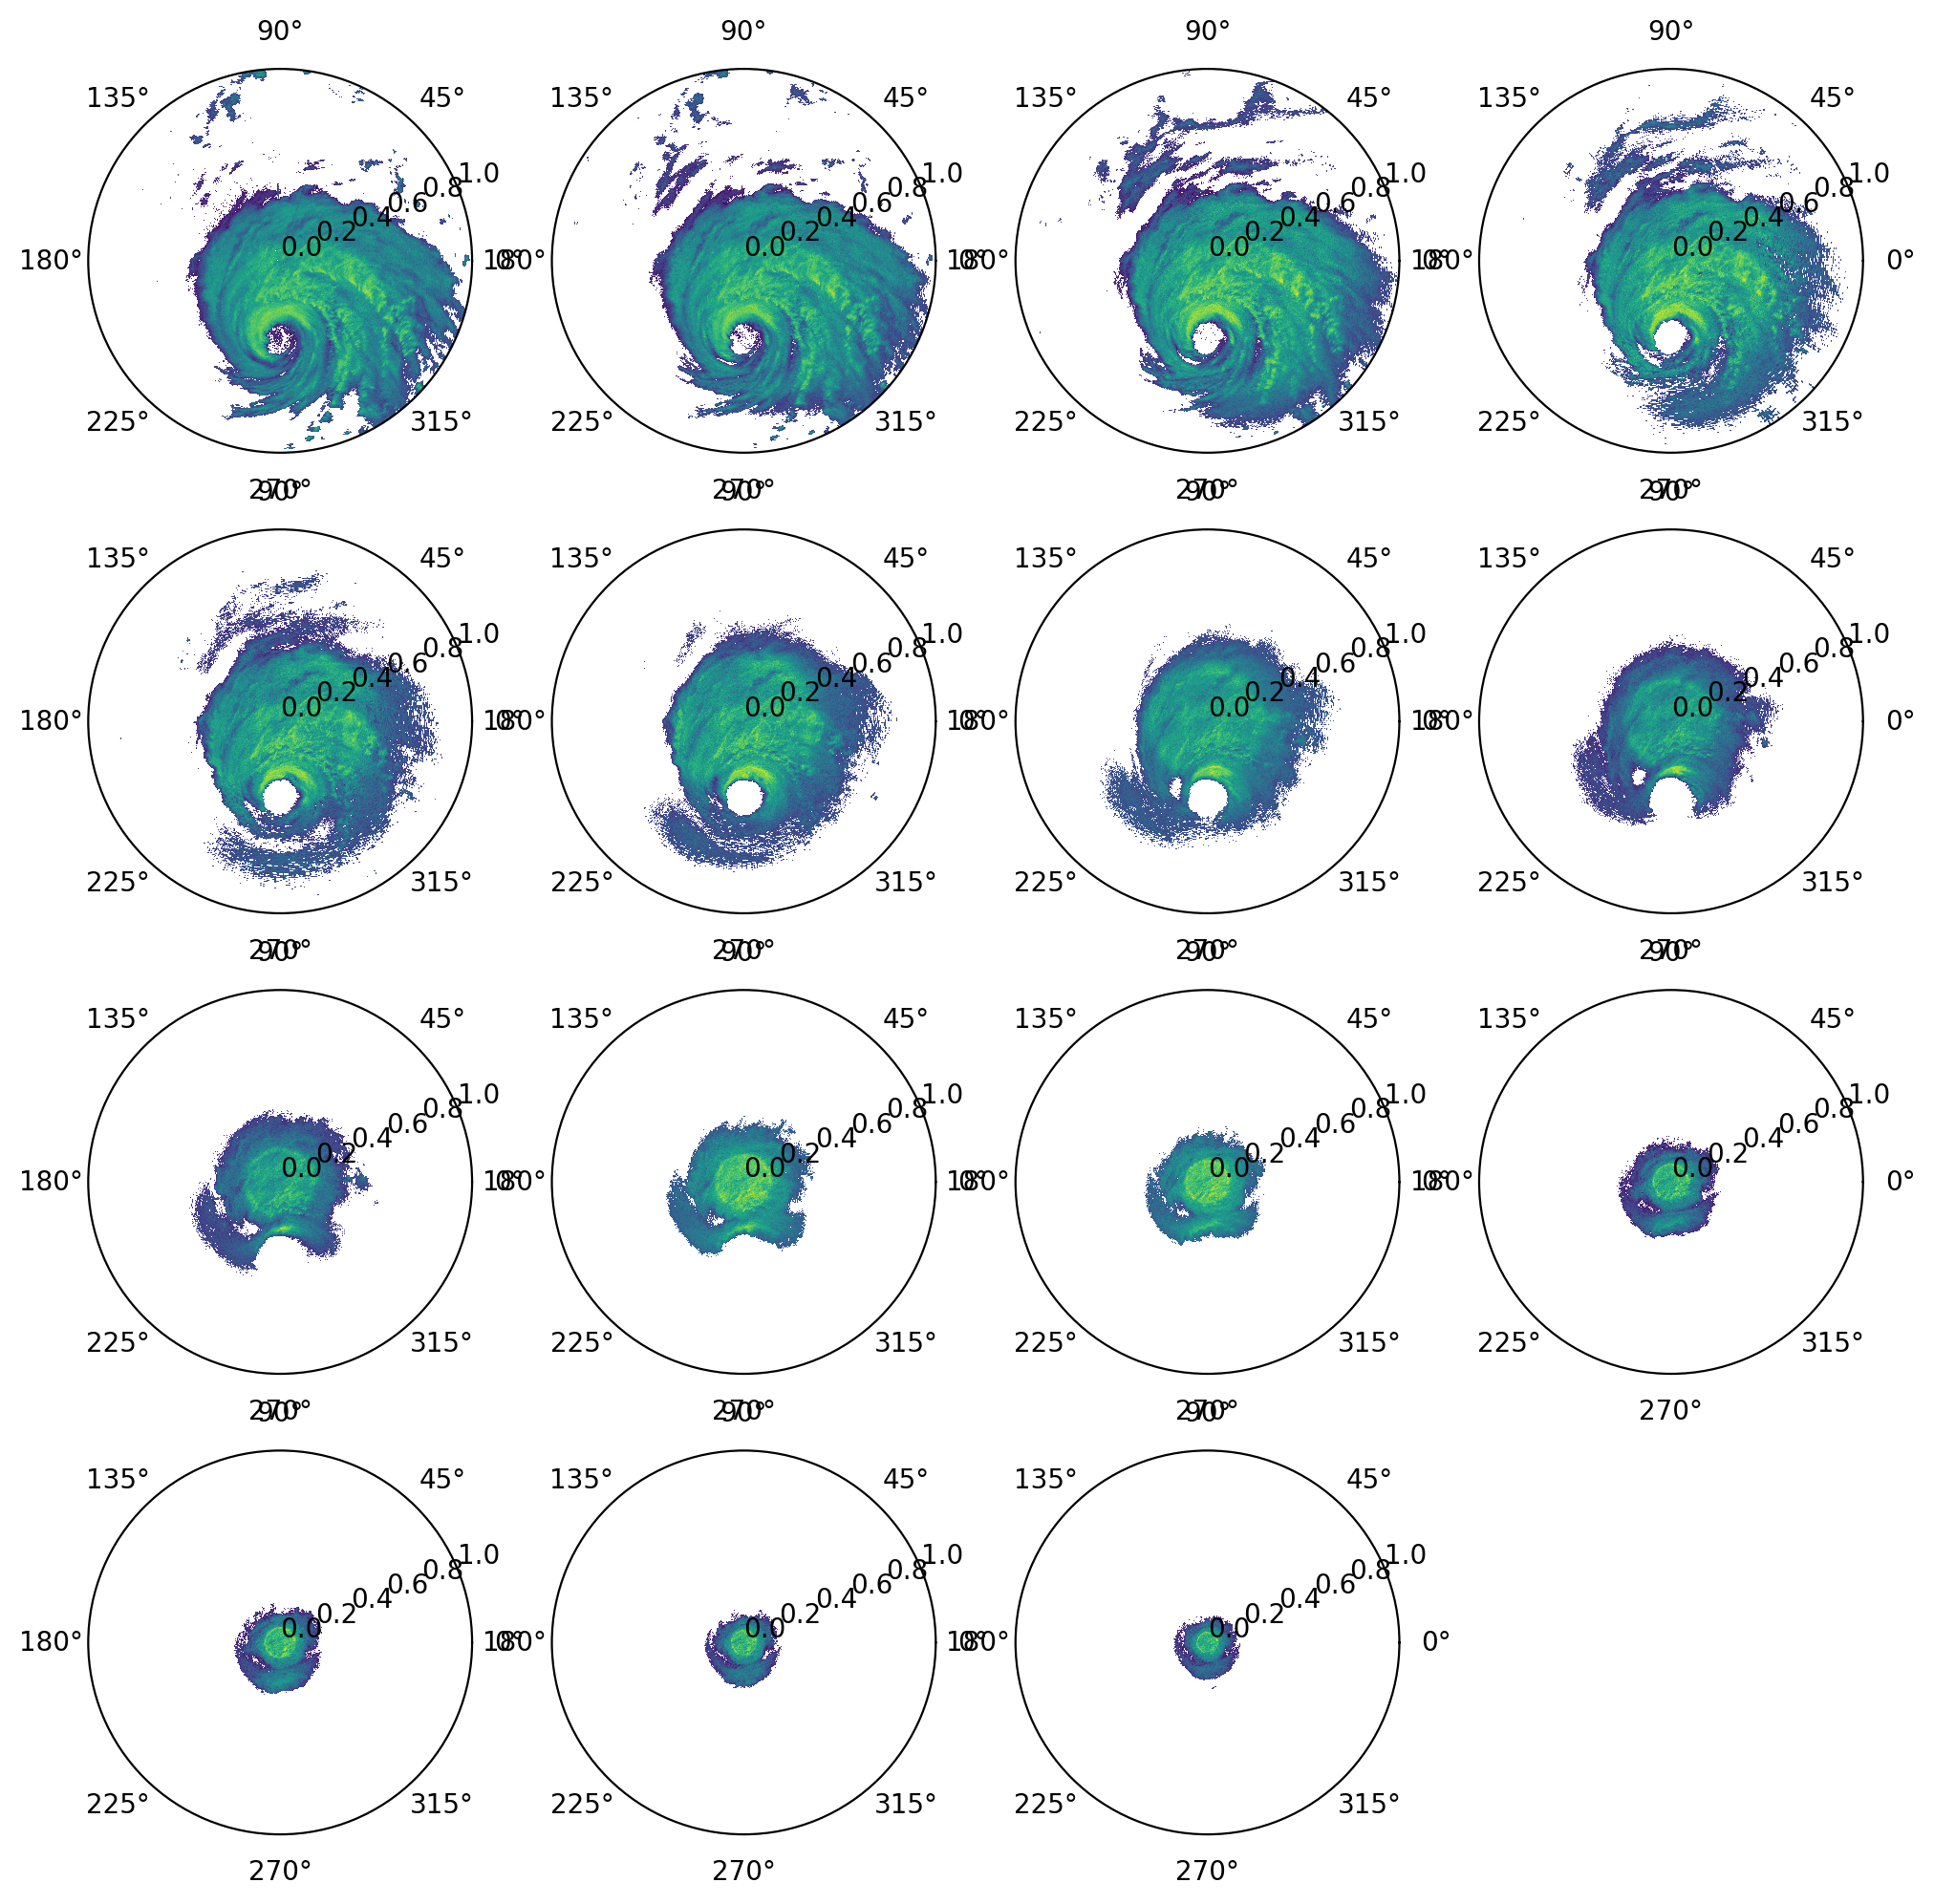

In [11]:
# plot each sweep
fig = plt.figure(figsize=(12,12))
radiusShown = min(1000, buffer.shape[2])
theta, rad = np.meshgrid(np.linspace(np.pi * 2.5, np.pi * 0.5, buffer.shape[1]), np.linspace(0, 1, radiusShown))
for i in range(buffer.shape[0]):
	ax = fig.add_subplot(math.ceil(math.sqrt(buffer.shape[0])), math.ceil(math.sqrt(buffer.shape[0])), i + 1, polar='True')
	ar = ax.pcolormesh(theta, rad, np.transpose(buffer[i,:,:radiusShown]), shading='auto')
plt.show()

In [23]:
# make an animation out of the files in a directory
if 1:
	print("start animation", end='\r')
	fig = plt.figure(figsize=(12,12))
	ax = fig.add_subplot(111, polar='True')

	animation_data_dir = "../files/hurricane/"
	animation_data_files = list(map(lambda x: animation_data_dir + x, os.listdir(animation_data_dir)))
	animation_data_files.sort()

	def drawframe(frame):
		print("frame", frame + 1, "             ", end='\r')
		time.sleep(0.05)
		radar_data.load_nexrad_file(animation_data_files[frame], openstorm_radar_py.VolumeTypes.VOLUME_REFLECTIVITY)
		print("frame", frame + 1, "loaded       ", end='\r')
		buffer = np.array(radar_data.buffer)[0,1:-1,:1000]
		theta, rad = np.meshgrid(np.linspace(np.pi * 2.5, np.pi * 0.5, buffer.shape[0]), np.linspace(0, 1, buffer.shape[1]))
		ax.clear()
		ar = ax.pcolormesh(theta, rad, np.transpose(buffer), shading='auto')
		return tuple([ar])
	anim = matplotlib.animation.FuncAnimation(fig, drawframe, frames=len(animation_data_files), interval=1000/30, blit=True)
	IPython.display.display(IPython.display.HTML(anim.to_html5_video()))
	plt.close()

In [13]:
#radar_data = None

In [14]:
# create RadarDataHolder object
radar_data_holder = openstorm_radar_py.RadarDataHolder()

In [15]:
# select products to be loaded
reflectivity_product = radar_data_holder.get_product(openstorm_radar_py.VolumeTypes.VOLUME_REFLECTIVITY)
velocity_product = radar_data_holder.get_product(openstorm_radar_py.VolumeTypes.VOLUME_VELOCITY)
# derived products
srv_product = radar_data_holder.get_product(openstorm_radar_py.VolumeTypes.VOLUME_STORM_RELATIVE_VELOCITY)
rotation_product = radar_data_holder.get_product(openstorm_radar_py.VolumeTypes.VOLUME_ROTATION)

In [16]:
# load file
radar_data_holder.load("../OpenStorm/Content/Data/Demo/KTLX20130531_231434_V06")
#radar_data_holder.load("../files/el-reno/compressed/KTLX20130531_231434_V06.gz")
# wait for it to finish loading because RadarDataHolder is asynchronous and multi-threaded
while(radar_data_holder.get_state() == openstorm_radar_py.RadarDataHolder.DataStateLoading):
	print("loading...", end='\r')
	time.sleep(0.1)
print("loaded      ", end='\n')

loaded      


In [17]:
# get now loaded RadarData objects from products
print("is reflectivity loaded?", reflectivity_product.is_loaded(), "   is velocity loaded?", velocity_product.is_loaded(), "   is srv loaded?", srv_product.is_loaded(), "   is rotation loaded?", rotation_product.is_loaded())
reflectivity_data = reflectivity_product.get_radar_data()
velocity_data = velocity_product.get_radar_data()
srv_data = srv_product.get_radar_data()
rotation_data = rotation_product.get_radar_data()
velocity_data.get_stats()

is reflectivity loaded? True    is velocity loaded? True    is srv loaded? True    is rotation loaded? True


{'inner_distance': 8.5,
 'min_value': -33.0,
 'max_value': 33.0,
 'pixel_size': 250.0,
 'begin_time': 1370042092.1780014,
 'end_time': 1370042343.552,
 'no_data_value': 0.0,
 'bound_radius': 1200.5,
 'bound_upper': 82.99691772460938,
 'bound_lower': 1.000000013351432e-10,
 'latitude': 35.333361,
 'longitude': -97.277761,
 'altitude': 389.535179070078,
 'volume_type': 2}

2780263943600 2780263943760 2780263936400 2780263936080


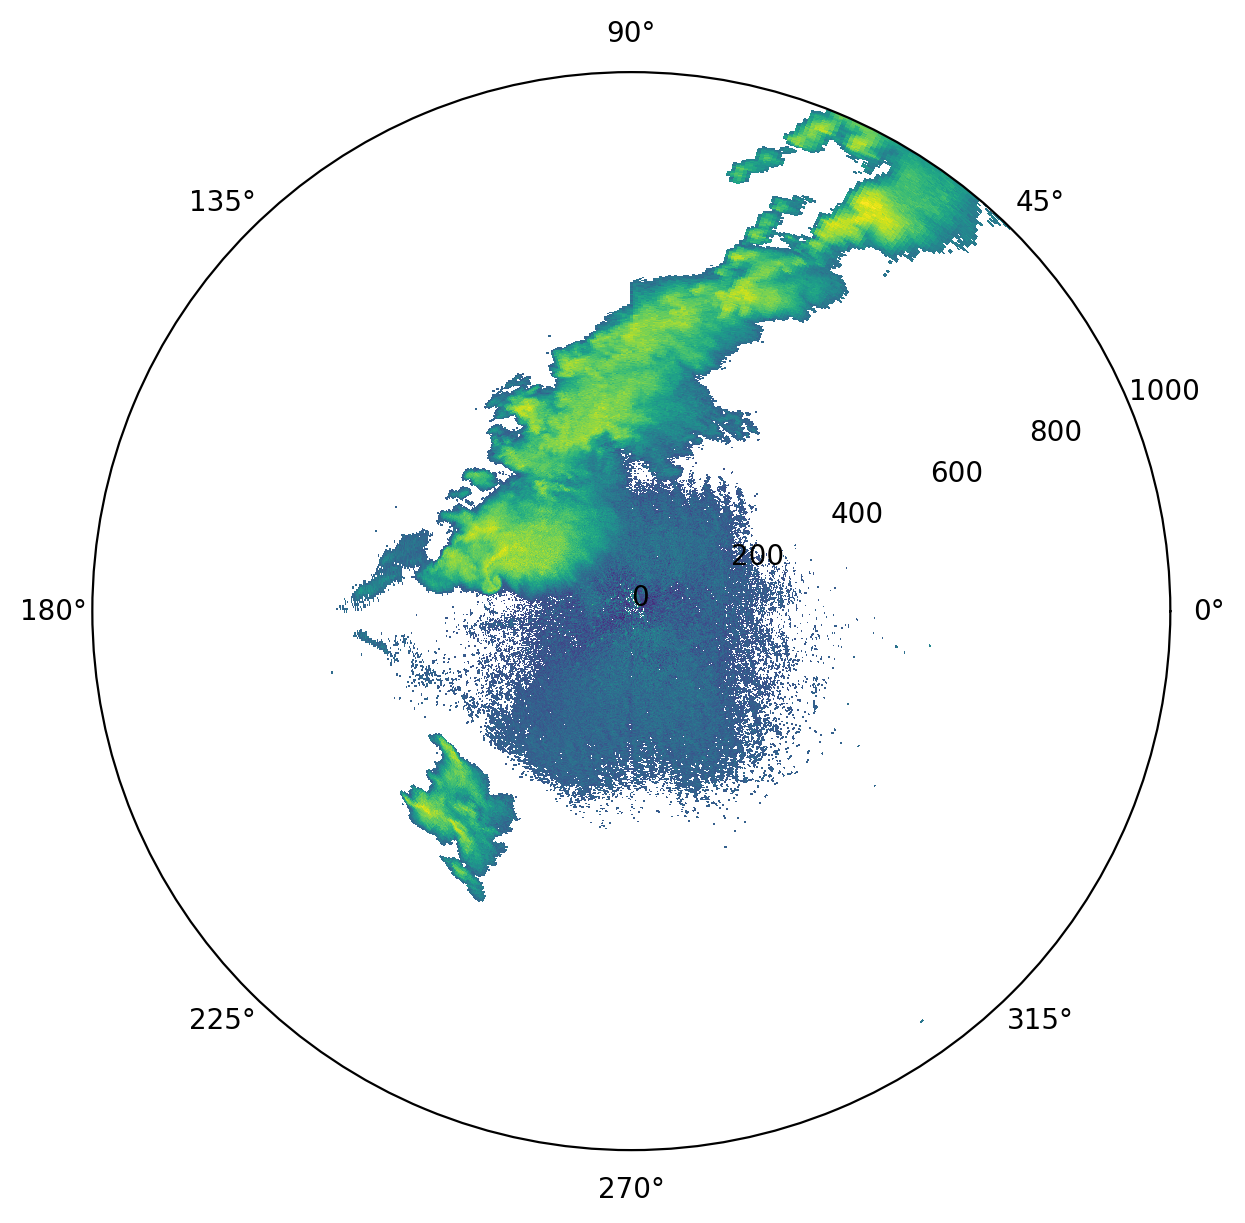

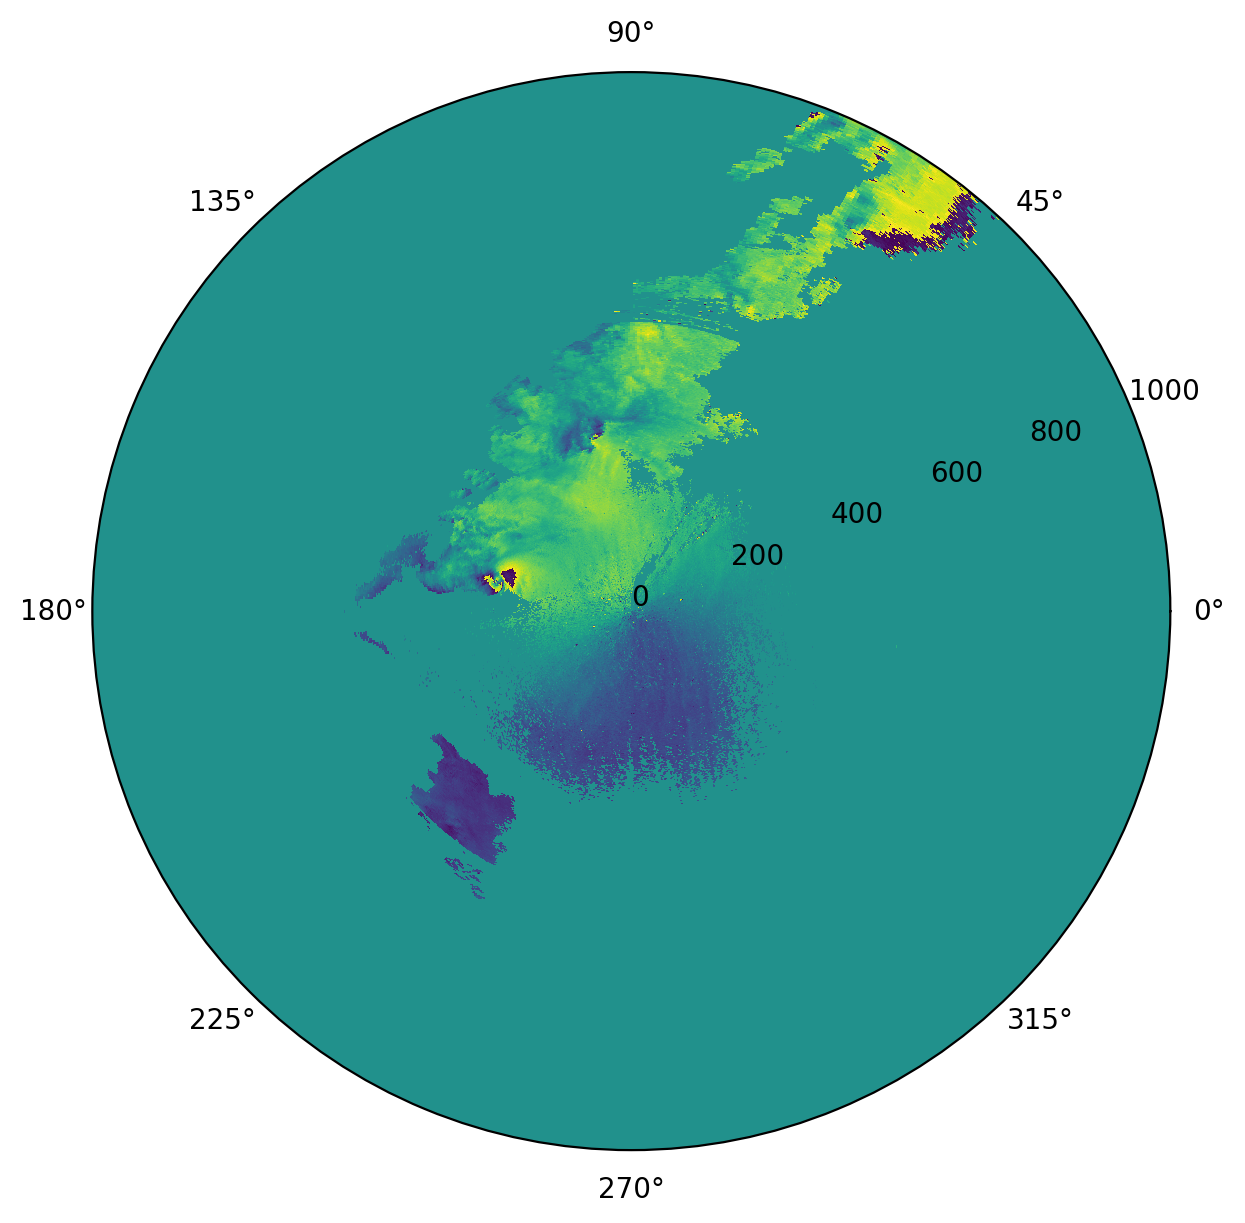

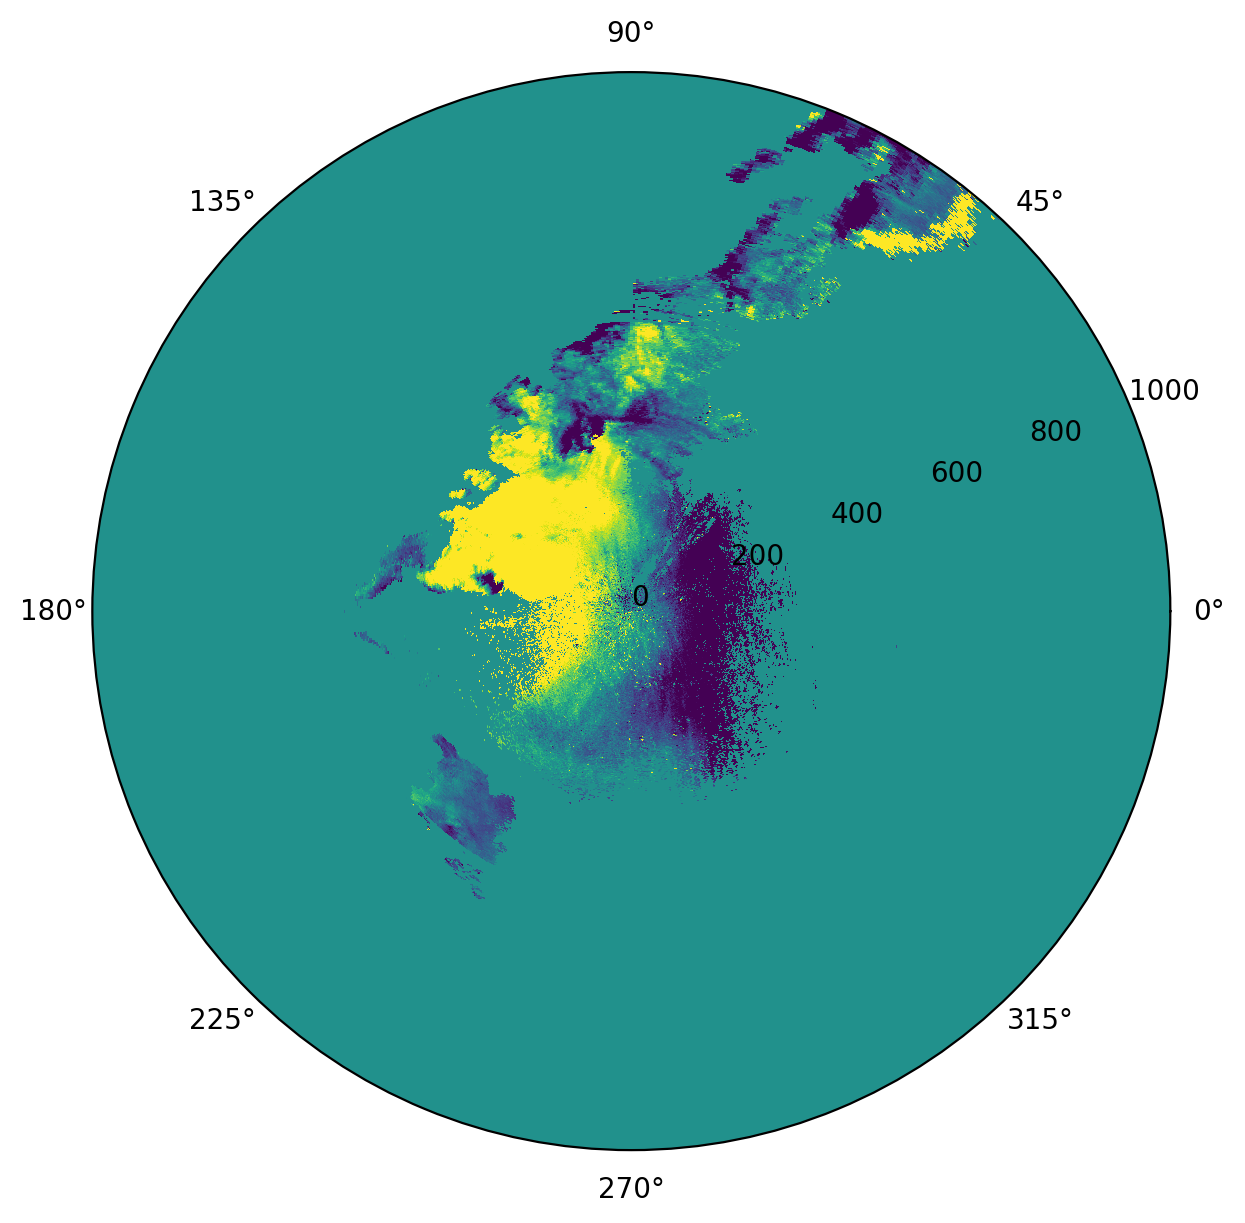

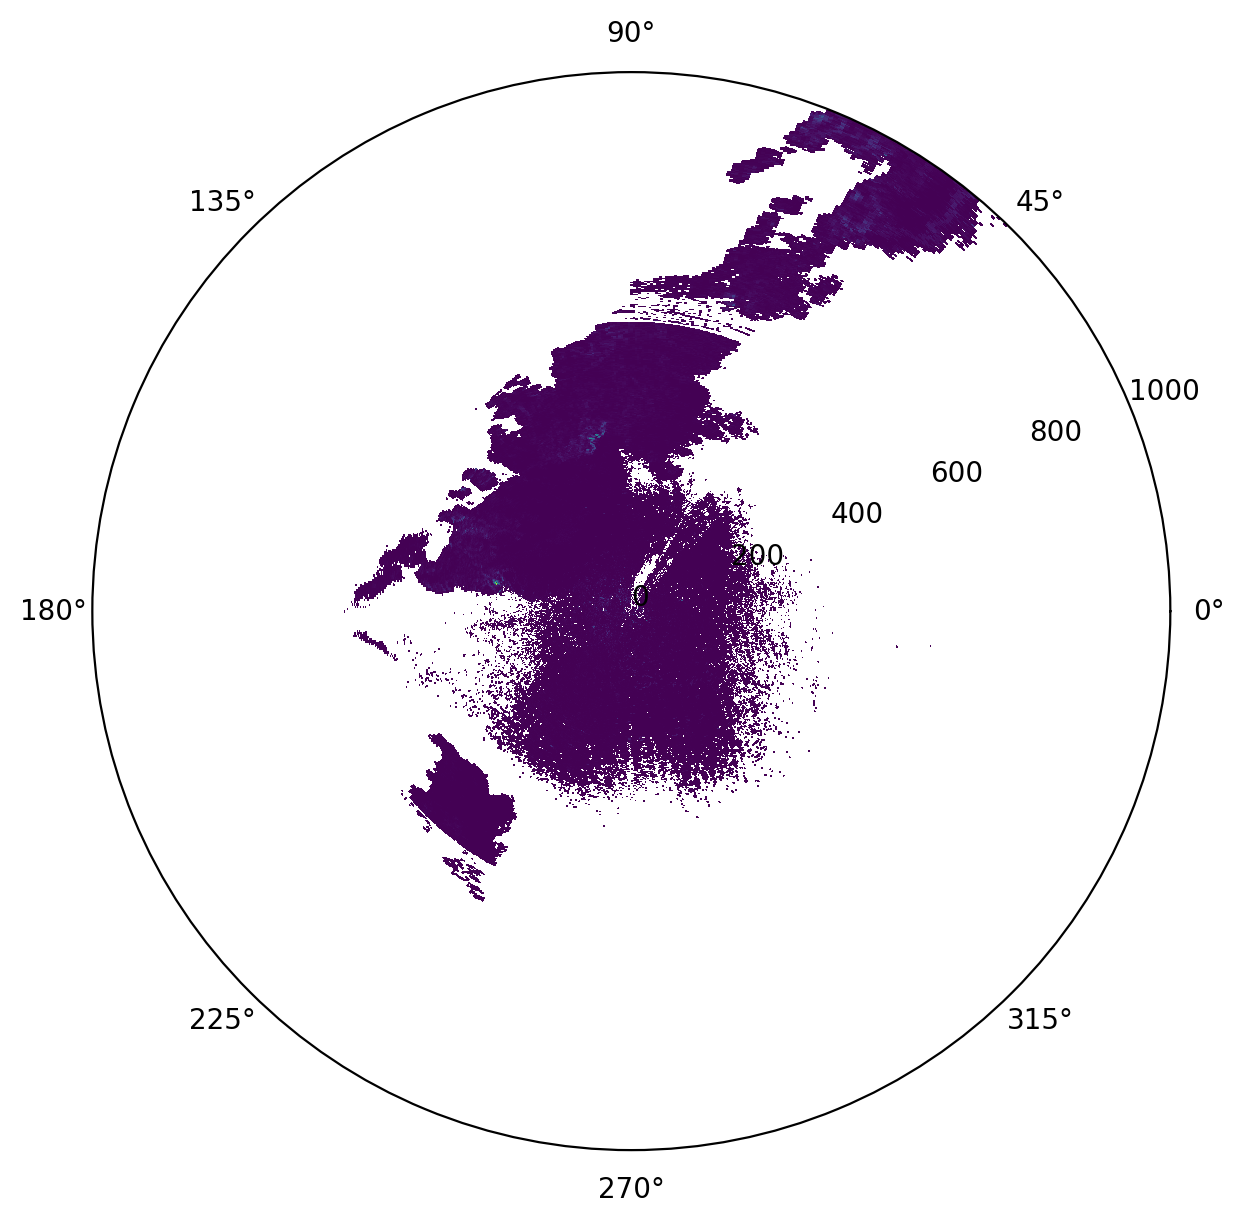

In [18]:
print(reflectivity_data._ptr, velocity_data._ptr, rotation_data._ptr, srv_data._ptr)
print(reflectivity_data.buffer)
#time.sleep(1)
plot_radial_image(np.array(reflectivity_data.buffer)[0,1:-1,:1000])
#time.sleep(0.5)
plot_radial_image(np.array(velocity_data.buffer)[0,1:-1,:1000])
#time.sleep(0.5)
plot_radial_image(np.clip(np.array(srv_data.buffer),-10, 10)[0,1:-1,:1000])
#time.sleep(0.5)
plot_radial_image(np.array(rotation_data.buffer)[0,1:-1,:1000])

In [19]:
# radar data will only be freed after radar_data_holder goes out of scope or is unloaded and all references to the radar data are gone
if 0:
	radar_data_holder.unload()
	reflectivity_data = None
	rotation_data = None
	srv_data = None
	reflectivity_product = None
	rotation_product = None
	srv_product = None
	
	radar_data = None

In [20]:
def stress_test():
	for i  in range(10000):
		radar_data_holder = openstorm_radar_py.RadarDataHolder()
		reflectivity_product = radar_data_holder.get_product(openstorm_radar_py.VolumeTypes.VOLUME_REFLECTIVITY)
		velocity_product = radar_data_holder.get_product(openstorm_radar_py.VolumeTypes.VOLUME_VELOCITY_DEALIASED)
		radar_data_holder.load("../OpenStorm/Content/Data/Demo/KTLX20130531_231434_V06")
		while(radar_data_holder.get_state() == openstorm_radar_py.RadarDataHolder.DataStateLoading):
			print("loading...", end='\r')
			time.sleep(0.1)
		print("loaded", i+1, "      ", end='\n')
		reflectivity_data = reflectivity_product.get_radar_data()
		velocity_data = velocity_product.get_radar_data()
		buffer = np.array(reflectivity_data.buffer)[0,1:-1,:1000]
		buffer = np.array(velocity_data.buffer)[0,1:-1,:]
#stress_test()

In [21]:
# plot data in real time
radar_data_realtime = openstorm_radar_py.RadarData(5, 720, 1000)
while 0:
	realtime_data_dir = "../radar-data/data/KMKX/"
	radar_data_realtime = openstorm_radar_py.RadarData()
	radar_data_realtime.load_nexrad_file(realtime_data_dir + os.listdir(realtime_data_dir)[-1], openstorm_radar_py.VolumeTypes.VOLUME_REFLECTIVITY)
	if radar_data_realtime.buffer is None:
		time.sleep(1)
		continue
	buffer = np.array(radar_data_realtime.buffer)[:,1:-1,:]
	fig = plt.figure(figsize=(12,12))
	radiusShown = min(1000, buffer.shape[2])
	theta, rad = np.meshgrid(np.linspace(np.pi * 2.5, np.pi * 0.5, buffer.shape[1]), np.linspace(0, 1, radiusShown))
	for i in range(buffer.shape[0]):
		ax = fig.add_subplot(math.ceil(math.sqrt(buffer.shape[0])), math.ceil(math.sqrt(buffer.shape[0])), i + 1, polar='True')
		ar = ax.pcolormesh(theta, rad, np.transpose(buffer[i,:,:radiusShown]), shading='auto')
	IPython.display.clear_output(wait=True)
	plt.show()

In [22]:
# recompress archive to gzip for faster loading but somewhat larger files
def recompress_test(file_name):
	size_before = os.path.getsize(file_name)
	openstorm_radar_py.recompress_nexrad_archive(file_name, "tmp_radar_file_test")
	size_after = os.path.getsize("tmp_radar_file_test")
	os.unlink("tmp_radar_file_test")
	print("before:", size_before, "after recompress:", size_after, "ratio:", size_after / size_before)

print("from bzip2 KLCH20200827_034044_V06")
recompress_test("../OpenStorm/Content/Data/Demo/KLCH20200827_034044_V06")
print("from bzip2 KMKX_20220723_235820")
recompress_test("../OpenStorm/Content/Data/Demo/KMKX_20220723_235820")
print("from uncompressed KTLX20130531_231434_V06")
recompress_test("../OpenStorm/Content/Data/Demo/KTLX20130531_231434_V06")
print("from gzip KHTX20110427_220236_V03")
recompress_test("../files/tornado-2011/KHTX20110427_220236_V03.gz")

from bzip2 KLCH20200827_034044_V06
before: 13844708 after recompress: 18385560 ratio: 1.3279846711104344
from bzip2 KMKX_20220723_235820
before: 15889883 after recompress: 20464985 ratio: 1.2879254680478138
from uncompressed KTLX20130531_231434_V06
before: 44897336 after recompress: 10210071 ratio: 0.22740928325903345
from gzip KHTX20110427_220236_V03
before: 7755026 after recompress: 7721010 ratio: 0.9956136833068
